# Assignment 3: PCA Analysis
                Group members: Xiang (Stacy) Li, Danjie (Michelle) Zhao

In [152]:
#load required packages
import pickle
from sklearn.metrics         import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as sk_pp
from sklearn.decomposition import PCA, KernelPCA
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding

# 1. Data Preparation

In assignment two, we used classification models to predict if the median earning of a school's students exceeds $30.6k. In this assignment, we will still use Random Forest Model to classify earnings. However, the dimensionality of the data will be reduced first. We want to know whether the reduction in dimensionality could increase the model accuracy.   

Before we start, let's import the data and add flag variable as we did in assignment two.

In [153]:
college = pickle.load(open("college.p","rb"))
college_label = pickle.load(open("college_label.p","rb"))
college_test = pickle.load(open("college_test.p","rb"))
college_test_label = pickle.load(open("college_test_label.p","rb"))
features = pd.read_csv('features.csv')#feature names

In [154]:
#find the median value
quantiles = college_label.quantile(q=0.5)

In [155]:
#write a function to encode median earnings to dummy variable
def median_code(data):
    if data < quantiles:
        return 0
    else:
        return 1

In [156]:
college_label_median = college_label.map(median_code)
college_test_label_median = college_test_label.map(median_code)

Before doing PCA, we first want to center the data so that the scale of variables won't influence the PCA result.

In [157]:
college_centered = college - college.mean(axis=0)
college_test_centered = college_test - college.mean(axis=0)

# 2. Choosing the right number of dimensions

We plan to use PCA in Scikit-Learn to implement PCA. There is a very important argument that we need to specify when using the PCA - the number of dimensions to reduce to. Instead of choosing an arbitrary number, we would like to choose the number of dimensions that add up to a sufficiently large portion of the variance.

In [158]:
pca = PCA()
pca.fit(college_centered)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [159]:
pca.explained_variance_ratio_[0:10]

array([ 0.39044101,  0.20941999,  0.07755925,  0.05390012,  0.03532041,
        0.03255564,  0.02523042,  0.02201691,  0.01682056,  0.01401534])

The first two components explains about 60% of the variance of the original X variables. Let's take a closer look at these two components.

In [160]:
E1, E2 = pd.DataFrame(pca.components_[0]), pd.DataFrame(pca.components_[1])
eigenvectors = pd.concat([features,E1,E2],axis = 1)
eigenvectors.columns = ['Features','E1','E2']
print(eigenvectors.head(20))

              Features        E1            E2
0   MedianFamilyIncome  0.504568  8.814541e-02
1     DebtNonCompleter  0.381319 -1.293074e-01
2             FirstGen -0.486701 -1.324599e-01
3              IndPerc -0.424426 -3.250677e-01
4             LoanPerc  0.127373 -6.345740e-01
5             NetPrice  0.258141 -5.676994e-01
6                   AK -0.132719 -2.402558e-01
7                   AL  0.147133 -1.423529e-02
8                   AR -0.014414  2.544911e-01
9                   AS -0.048196  4.528846e-02
10                  AZ  0.195082  5.741809e-03
11                  CA -0.138619 -3.349732e-02
12                  CO  0.001959 -4.597992e-07
13                  CT -0.010226 -1.753249e-02
14                  DC -0.000237  4.754260e-04
15                  DE  0.000304  3.375011e-03
16                  FL -0.001362  3.846081e-03
17                  FM -0.000044  4.012223e-04
18                  GA -0.003924 -5.350365e-03
19                  GU -0.010737 -3.199662e-03


The first component is strongly correlated with `MedianFamilyIncome`, and `FirstGen`. To be more specific, the first component can be viewed as a measure of family impact. It increases as median family income increases, and as percentage of students who are the first one to receive higher education in their family decreases.   

The second component is strongly correlated with `NetPrice` and `IndPerc`. This component can be viewed as a measure of the financial burden of students in that campus. If the campus has a low percent of financial independent student and high net price, indicating students have a relatively heavier financial burden, this component will have higher values.

Before applying PCA to predictive models, we need to find out the number of dimensions that add up to a sufficiently large portion of the variance. In our case, we want to know how many dimensions that could explain 90% and 95% of the variance. 

In [161]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [162]:
d1 = np.argmax(cumsum >= 0.90) + 1
d2 = np.argmax(cumsum >= 0.95) + 1
print(d1, d2)

13 25


Therefore, for the next step, we will build random forest models using 13 components and 25 components respectively.

# 3.  Random Forest Model with 13 components

### 3.1 Random forest model with PCA

In [163]:
pca = PCA(n_components=d1, random_state = 42)
college_reduced = pca.fit_transform(college_centered)
rf_clf = RandomForestClassifier(random_state = 42)

#### Performance comparison on the train set

We would like to evaluate th model performance on training data.

In [164]:
pred_rf_reduced = cross_val_predict(rf_clf, college_reduced, college_label_median, cv=3)
pred_rf = cross_val_predict(rf_clf, college, college_label_median, cv=3)

Then we compare the Random Forest model with 13 Principal Components with the model without PCA.

In [165]:
print('Random Forest with 13 PC\n' + classification_report(college_label_median, pred_rf_reduced))
print('Random Forest without PCA\n' + classification_report(college_label_median, pred_rf)) 

Random Forest with 13 PC
             precision    recall  f1-score   support

          0       0.77      0.85      0.81      2403
          1       0.83      0.74      0.79      2404

avg / total       0.80      0.80      0.80      4807

Random Forest without PCA
             precision    recall  f1-score   support

          0       0.80      0.87      0.83      2403
          1       0.86      0.78      0.82      2404

avg / total       0.83      0.82      0.82      4807



From the classification report, we can see that the random forest model without PCA outperforms the random forest model with PCA.

#### Performance comparison on the test set

Next, we evaluate model performance on the testing data.

In [166]:
college_test_reduced = pca.fit_transform(college_test_centered)
rf_clf.fit(college_reduced, college_label_median)
test_pred_reduced = rf_clf.predict(college_test_reduced)

In [167]:
rf_clf.fit(college, college_label_median)
test_pred = rf_clf.predict(college_test)

In [168]:
print('Random Forest with 13 PC\n' + classification_report(college_test_label_median,test_pred_reduced)) 
print('Random Forest without PCA\n' + classification_report(college_test_label_median,test_pred)) 

Random Forest with 13 PC
             precision    recall  f1-score   support

          0       0.69      0.69      0.69       612
          1       0.70      0.70      0.70       631

avg / total       0.70      0.70      0.70      1243

Random Forest without PCA
             precision    recall  f1-score   support

          0       0.86      0.92      0.89       612
          1       0.91      0.85      0.88       631

avg / total       0.89      0.88      0.88      1243



The random forest model performs even worse on the test set when we apply PCA to it.

##  3.2 Random forest model with Kernel PCA

In this part, the kernel PCA is applied to the random forest model. We will use grid search to select the kernel and hyperparameters that lead to the best performance.  The whole process can be separate into three steps:  

1. Reduce dimensionality to 13 dimensions using KPCA, then applying random forest classifier for classification. 
2. Use GridSearchCV to find the best kernel and gamma value for KPCA in order to get the best classification accuracy.
3. Evaluate the performance of model with the best parameter combination.

In [169]:
clf = Pipeline([
        ('kpca', KernelPCA(n_components=13, random_state = 42)),
        ('rf_clf', RandomForestClassifier(random_state = 42))
    ])

param_grid = [{
        "kpca__gamma" : np.linspace(0.05, 0.15, 5),
        "kpca__kernel" :['rbf', 'sigmoid','poly']
    }]

grid_search = GridSearchCV(clf, param_grid, cv = 3, scoring = 'accuracy')
grid_search.fit(college_centered, college_label_median)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=13, n_jobs=1,
     random_state=42, remove_zero_eig=False, tol=0)), ('rf_clf', RandomForestCla...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kpca__kernel': ['rbf', 'sigmoid', 'poly'], 'kpca__gamma': array([ 0.05 ,  0.075,  0.1  ,  0.125,  0.15 ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [170]:
print(grid_search.best_params_)

{'kpca__kernel': 'poly', 'kpca__gamma': 0.074999999999999997}


Let's use the above parameters to build a random forest model with kernal PCA applied on the training set.

In [171]:
clf = Pipeline([
        ('kpca', KernelPCA(n_components=13, random_state = 42, gamma=0.075, kernel='sigmoid')),
        ('rf_clf', RandomForestClassifier(random_state = 42))
    ])
clf.fit(college_centered, college_label_median)

Pipeline(steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=0.075, kernel='sigmoid',
     kernel_params=None, max_iter=None, n_components=13, n_jobs=1,
     random_state=42, remove_zero_eig=False, tol=0)), ('rf_clf', RandomForestC...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])

** Performance on training set **

In [172]:
clf_pred = cross_val_predict(clf, college_centered, college_label_median)

In [173]:
print('Random Forest with Kernel 13 PC\n' + classification_report(college_label_median,clf_pred))
print('Random Forest with 13 PC\n' + classification_report(college_test_label_median,test_pred_reduced)) 
print('Random Forest without PCA\n' + classification_report(college_test_label_median,test_pred)) 

Random Forest with Kernel 13 PC
             precision    recall  f1-score   support

          0       0.78      0.85      0.81      2403
          1       0.84      0.76      0.79      2404

avg / total       0.81      0.80      0.80      4807

Random Forest with 13 PC
             precision    recall  f1-score   support

          0       0.69      0.69      0.69       612
          1       0.70      0.70      0.70       631

avg / total       0.70      0.70      0.70      1243

Random Forest without PCA
             precision    recall  f1-score   support

          0       0.86      0.92      0.89       612
          1       0.91      0.85      0.88       631

avg / total       0.89      0.88      0.88      1243



The performance is still worse than the random forest model without kernel PCA.

** Performance on test set **

In [174]:
clf_pred_test = clf.predict(college_test_centered)

In [175]:
print('Random Forest with Kernel 13 PC\n' + classification_report(college_test_label_median,clf_pred_test))
print('Random Forest with 13 PC\n' + classification_report(college_test_label_median,test_pred_reduced)) 
print('Random Forest without PCA\n' + classification_report(college_test_label_median,test_pred)) 

Random Forest with Kernel 13 PC
             precision    recall  f1-score   support

          0       0.83      0.89      0.86       612
          1       0.88      0.83      0.86       631

avg / total       0.86      0.86      0.86      1243

Random Forest with 13 PC
             precision    recall  f1-score   support

          0       0.69      0.69      0.69       612
          1       0.70      0.70      0.70       631

avg / total       0.70      0.70      0.70      1243

Random Forest without PCA
             precision    recall  f1-score   support

          0       0.86      0.92      0.89       612
          1       0.91      0.85      0.88       631

avg / total       0.89      0.88      0.88      1243



On the testing set, the kernel PCA works better than linear PCA in the random forest model. But random forest model with complete dimensionality is still the best model.

##  3.3 Random forest model with Locally Linear Embedding

In the following part, we are going to use another commonly used dimension reduction technique Locally Linear Embedding to reduce the dimensionity of data. First, we use a grid search to help us find the optimal number of nerighbors.

In [176]:
clf = Pipeline([
        ('lle', LocallyLinearEmbedding(n_components=13)),
        ('rf_clf', RandomForestClassifier(random_state = 42))
    ])

param_grid = [{
        "lle__n_neighbors" : [50, 70, 90],
    }]

grid_search = GridSearchCV(clf, param_grid, cv = 3, scoring = 'accuracy')
grid_search.fit(college_centered, college_label_median)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('lle', LocallyLinearEmbedding(eigen_solver='auto', hessian_tol=0.0001, max_iter=100,
            method='standard', modified_tol=1e-12, n_components=13,
            n_jobs=1, n_neighbors=5, neighbors_algorithm='auto',
            random_state=None, reg=0.001, tol=1e-06)), ('rf_clf', RandomFo...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'lle__n_neighbors': [50, 70, 90]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [177]:
print(grid_search.best_params_)

{'lle__n_neighbors': 70}


The optimal number of nerighbors is 70.

** Performance on training set **

Let's build a model using best parameter and then evaluate the performance on the training set.

In [178]:
lle = LocallyLinearEmbedding(n_components=13, n_neighbors=70)
X_reduced = lle.fit_transform(college_centered)

rf_clf = RandomForestClassifier(random_state = 42)
pred_rf_reduced_lle = cross_val_predict(rf_clf, X_reduced, college_label_median, cv=3)

print('Random Forest with LLE 13 PC\n' + classification_report(college_label_median, pred_rf_reduced_lle))

Random Forest with LLE 13 PC
             precision    recall  f1-score   support

          0       0.72      0.83      0.77      2403
          1       0.80      0.67      0.73      2404

avg / total       0.76      0.75      0.75      4807



From the classification report, we see that the Random Forest model with LLE performs worse than Kernal PCA and model without PCA, but better than model with baseline model (the one without Kernel).

** Performance on testing set **

In [179]:
college_test_reduced = lle.fit_transform(college_test_centered)
rf_clf.fit(X_reduced, college_label_median)
test_pred_reduced_lle = rf_clf.predict(college_test_reduced)
print('Random Forest with 13 PC\n' + classification_report(college_test_label_median, test_pred_reduced_lle))

Random Forest with 13 PC
             precision    recall  f1-score   support

          0       0.49      0.65      0.56       612
          1       0.51      0.35      0.41       631

avg / total       0.50      0.50      0.49      1243



The Random Forest model with LLE badly on the testing set.

# 4. Random Forest Model with 25 components 

After building a random forest model with 13 principal conponents, we also would liket to see if the model accuracy will improve if we increase the number of principal components used.

## 4.1 Ramdon Forest with PCA

First of all, we transform original variables into 25 principal components.

In [180]:
#25 components
pca1 = PCA(n_components=d2, random_state = 42)
college_reduced1 = pca1.fit_transform(college_centered)
rf_clf1 = RandomForestClassifier(random_state = 42)

### Performance comparison on training data

Let'e evaluate the model performance on training data and compare the result with that of 13 principal components and that without principal component analysis.

In [181]:
pred_rf_reduced1 = cross_val_predict(rf_clf1, college_reduced1, college_label_median, cv=3)

In [182]:
print('Random Forest without PCA\n' + classification_report(college_label_median, pred_rf))
print('Random Forest with 13 PC\n' + classification_report(college_label_median, pred_rf_reduced))
print('Random Forest with 25 PC\n' + classification_report(college_label_median, pred_rf_reduced1)) 

Random Forest without PCA
             precision    recall  f1-score   support

          0       0.80      0.87      0.83      2403
          1       0.86      0.78      0.82      2404

avg / total       0.83      0.82      0.82      4807

Random Forest with 13 PC
             precision    recall  f1-score   support

          0       0.72      0.83      0.77      2403
          1       0.80      0.67      0.73      2404

avg / total       0.76      0.75      0.75      4807

Random Forest with 25 PC
             precision    recall  f1-score   support

          0       0.74      0.84      0.79      2403
          1       0.82      0.70      0.75      2404

avg / total       0.78      0.77      0.77      4807



We see that models with 25 components performs worse than that with 13 components on the training data.

### Performance on testing data

In [183]:
college_test_reduced1 = pca1.fit_transform(college_test_centered)
rf_clf1.fit(college_reduced1, college_label_median)
test_pred_reduced1 = rf_clf1.predict(college_test_reduced1)

In [184]:
print('Random Forest with 25 PC\n' + classification_report(college_test_label_median,test_pred_reduced1))
print('Random Forest with 13 PC\n' + classification_report(college_test_label_median,test_pred_reduced))
print('Random Forest without PCA\n' + classification_report(college_test_label_median,test_pred))

Random Forest with 25 PC
             precision    recall  f1-score   support

          0       0.67      0.72      0.69       612
          1       0.71      0.66      0.68       631

avg / total       0.69      0.69      0.69      1243

Random Forest with 13 PC
             precision    recall  f1-score   support

          0       0.49      0.65      0.56       612
          1       0.51      0.35      0.41       631

avg / total       0.50      0.50      0.49      1243

Random Forest without PCA
             precision    recall  f1-score   support

          0       0.86      0.92      0.89       612
          1       0.91      0.85      0.88       631

avg / total       0.89      0.88      0.88      1243



Similarly, the 25-component solution has worse performance than the 13-component solution and the model without PCA. Then let's see if using Kernal PCA is going to improve the performance.

### 4.2 Random forest model with Kernel PCA

We will do Kernal PCA with 25 components and use GridSearchCV to find the best kernel and gamma value.

In [ ]:
clf1 = Pipeline([
        ('kpca', KernelPCA(n_components=25, random_state = 42)),
        ('rf_clf', RandomForestClassifier(random_state = 42))
    ])

param_grid1 = [{
        "kpca__gamma" : np.linspace(0.05, 0.15, 5),
        "kpca__kernel" :['rbf', 'sigmoid','poly']
    }]

grid_search1 = GridSearchCV(clf1, param_grid1, cv = 3, scoring = 'accuracy')
grid_search1.fit(college_reduced, college_label_median)

In [ ]:
print(grid_search1.best_params_)

The best kernel is `poly` and the best gamma value is `0.15`. Then we build a random forest model with the best parameters.

In [ ]:
clf1 = Pipeline([
        ('kpca', KernelPCA(n_components=25, random_state = 42, gamma=0.15, kernel='poly')),
        ('rf_clf', RandomForestClassifier(random_state = 42))
    ])
clf1.fit(college_centered, college_label_median)

In [ ]:
clf_pred1 = cross_val_predict(clf1, college_centered, college_label_median)

In [ ]:
print('Random Forest with Kernel 25 PC\n' + classification_report(college_label_median, clf_pred1)) 
print('Random Forest with 25 PC\n' + classification_report(college_label_median, pred_rf_reduced1))
print('Random Forest with Kernel 13 PC\n' + classification_report(college_label_median,clf_pred))
print('Random Forest without PCA\n' + classification_report(college_label_median, pred_rf))

The performance of model with 25 components using Kernel PCA is better than PCA without Kernel and it performs as well as 13-component solution with kernel. Still, the random forest model without PCA is the best model.

In [ ]:
clf_pred_test1 = clf1.predict(college_test_centered)
print('Random Forest with Kernel 25 PC\n' + classification_report(college_test_label_median,clf_pred_test1))
print('Random Forest with 25 PC\n' + classification_report(college_test_label_median,test_pred_reduced1))
print('Random Forest without PCA\n' + classification_report(college_test_label_median,test_pred))
print('Random Forest with Kernel 13 PC\n' + classification_report(college_test_label_median,clf_pred_test))

We see similar performance on the testing data. The 25-component solution with Kernel is better than the solution without kernel but still worse than the model without PCA.

## 4.3 Random forest model with Locally Linear Embedding

We also apply Locally Linear Embedding to create 25 components as input of the Random Forest Model.

In [113]:
clf = Pipeline([
        ('lle', LocallyLinearEmbedding(n_components=25, n_neighbors=40)),
        ('rf_clf', RandomForestClassifier(random_state = 42))
    ])

param_grid = [{
        "lle__n_neighbors" : [50, 70, 90],
    }]

grid_search = GridSearchCV(clf, param_grid, cv = 3, scoring = 'accuracy')
grid_search.fit(college_centered, college_label_median)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('lle', LocallyLinearEmbedding(eigen_solver='auto', hessian_tol=0.0001, max_iter=100,
            method='standard', modified_tol=1e-12, n_components=25,
            n_jobs=1, n_neighbors=40, neighbors_algorithm='auto',
            random_state=None, reg=0.001, tol=1e-06)), ('rf_clf', RandomF...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'lle__n_neighbors': [50, 70, 90]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

The optimal number fo neighbors is 70.

In [115]:
print(grid_search.best_params_)

{'lle__n_neighbors': 70}


**Performance on the training set**

After finding the best parameter, let's evaluate the model performance on training data set.

In [116]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=25, n_neighbors=70)
X_reduced = lle.fit_transform(college_centered)

rf_clf = RandomForestClassifier(random_state = 42)
pred_rf_reduced_lle = cross_val_predict(rf_clf, X_reduced, college_label_median, cv=3)

print('Random Forest with LLE 25 PC on training\n' + classification_report(college_label_median, pred_rf_reduced_lle))

Random Forest with 13 PC
             precision    recall  f1-score   support

          0       0.72      0.84      0.77      2403
          1       0.81      0.68      0.73      2404

avg / total       0.76      0.76      0.75      4807



**Performance on the testing set**

In [117]:
college_test_reduced = lle.fit_transform(college_test_centered)
rf_clf.fit(X_reduced, college_label_median)
test_pred_reduced_lle = rf_clf.predict(college_test_reduced)
print('Random Forest with LLE 25 PC on testing\n' + classification_report(college_test_label_median, test_pred_reduced_lle))

Random Forest with 13 PC
             precision    recall  f1-score   support

          0       0.51      0.71      0.59       612
          1       0.54      0.33      0.41       631

avg / total       0.52      0.52      0.50      1243



# 5. How will model accuracy change when we  use more components

From the above analysis, we see that as the number of components used increase, the model accuracy decreases. Is it always the case? Let's create a plot to show how the model performance change when we increase the number of components used.

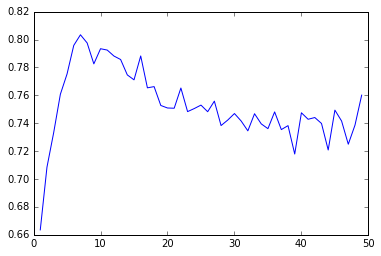

In [134]:
f1_set = []
f1_test_set = []
for i in range(1,50):
    pca = PCA(n_components=i, random_state = 42)
    college_reduced = pca.fit_transform(college_centered)
    rf_clf = RandomForestClassifier(random_state = 42)
    pred_rf_reduced = cross_val_predict(rf_clf, college_reduced, college_label_median, cv=3)
    f1 = f1_score(college_label_median, pred_rf_reduced)
    f1_set.append(f1)
    
plt.plot(range(1,50), f1_set)
plt.show()

The plot above shows how the cross-validation error changes as the number of components used increases. We notice that when the number of components used is less than 9, using more components will increase model accuracy. But as the number of components continues to increase, the performance of model starts decrease and become unstable.

# 5. Conclusion

From the analysis above, we see that performing PCA doesn't necessarily improve the performance of the model in this specific case. 

We use 13 components and 25 components to build random forest models and the 13-component solution seems to perform better than 25-component solution. Also, doing PCA with Kernel improves the the accuracy of the model. Although PCA doesn't increase the model accuracy in this specific case. It gives us a better understanding of how factors relate to each other and helps reduce the model complexity. 

With further research, we realize that PCA is not always a good method to use when building predictive model. It could increase the performance in some cases but could decrease model performance in other cases. We should always consider using the original data first. The conclusion is that we had better use PCA when the dimension of data is large and we want to reduce the variables to boost the training speed and decrease model complexity.

The end.